# [1-EDA] - Analyse exploratoire des données

## Import des modules
> cf. [pyproject.toml](pyproject.toml) pour connaître les librairies à installer

In [1]:
import os
import io
import math
import boto3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import matplotlib.pyplot as plt

## Récupération des données dans le stockage objet AWS S3

In [2]:
# Configutations S3 access and data
load_dotenv()
aws_access_key_id = os.getenv('aws_access_key_id')
aws_secret_access_key = os.getenv('aws_secret_access_key')

In [3]:
# Specific bucket data
bucket_name = "hotel-resa-prediction"
prefix = "datasets/"
filename_train = "hotel_bookings.csv"

In [4]:
# S3 connection
s3 = boto3.client(
    service_name = "s3",
    region_name = "eu-west-3",
    aws_access_key_id = aws_access_key_id,
    aws_secret_access_key = aws_secret_access_key,
)

In [5]:
# get datas 
result = s3.list_objects(Bucket=bucket_name)
for obj in result.get('Contents'):
    if (obj["Key"].startswith(prefix)) and (obj["Key"].endswith(filename_train)):
        data = s3.get_object(Bucket=bucket_name, Key=obj.get('Key'))
        contents = data['Body'].read().decode("utf-8")
        data = pd.read_csv(io.StringIO(contents), low_memory=False)

In [6]:
data.head().T

,0,1,2,3,4
hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel
is_canceled,0,0,0,0,0
lead_time,342,737,7,13,14
arrival_date_year,2015,2015,2015,2015,2015
arrival_date_month,July,July,July,July,July
arrival_date_week_number,27,27,27,27,27
arrival_date_day_of_month,1,1,1,1,1
stays_in_weekend_nights,0,0,0,0,0
stays_in_week_nights,0,0,1,1,2
adults,2,2,1,1,2


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## Cadrage du sujet et problématique 

### Contexte
Dans le secteur hotelier, une part importante des chambres réservés est finalement annulée.<br/>
Ces annulations réduisent le taux d’occupation effectif et les revenus et compliquent la planification du personnel et la gestion du sur-booking. Anticiper le risque qu’une réservation soit annulée permet donc d’ajuster la politique tarifaire (dépôts, conditions d’annulation), de déclencher des actions de réassurance client et d’optimiser le sur-booking.

### Objectif
Le but est de développer et valider un modèle global de classification binaire qui décide, pour chaque réservation confirmée, si elle sera annulée ou non avant la date d’arrivée.


### Base de données
Nous utilisons le jeu Hotel Bookings (City Hotel et Resort Hotel), couvrant la période de juillet 2015 à août 2017.
Chaque ligne représente une réservation unique, finalisée (confirmée ou annulée). Le jeu comprend environ 120 000.

La base de données contient les variables suivantes :

| Nom                                                             | Description (valeur ou codage)                                                         |
| --------------------------------------------------------------- | -------------------------------------------------------------------------------------- |
| **is\_canceled**                                                | **1** si la réservation a été annulée (cible), **0** sinon.                            |
| **hotel**                                                       | Type d’hôtel : *Resort* ou *City*.                                                     |
| **lead\_time**                                                  | Jours entre la date de réservation et la date d’arrivée.                               |
| **arrival\_date\_year / month / week\_number / day\_of\_month** | Composants calendaires de la date d’arrivée.                                           |
| **stays\_in\_weekend\_nights**                                  | Nuits week-end réservées.                                                              |
| **stays\_in\_week\_nights**                                     | Nuits semaine réservées.                                                               |
| **adults / children / babies**                                  | Composition du groupe.                                                                 |
| **meal**                                                        | Formule repas réservée (BB, HB, SC, etc.).                                             |
| **country**                                                     | Code ISO du pays du client.                                                            |
| **market\_segment**                                             | Segment commercial (Online TA, Direct, Corporate, …).                                  |
| **distribution\_channel**                                       | Canal (TA/TO, Direct, GDS, Corporate).                                                 |
| **is\_repeated\_guest**                                         | 1 si client déjà venu.                                                                 |
| **previous\_cancellations**                                     | Nombre d’annulations antérieures.                                                      |
| **previous\_bookings\_not\_canceled**                           | Réservations antérieures honorées.                                                     |
| **reserved\_room\_type**                                        | Catégorie de chambre demandée.                                                         |
| **assigned\_room\_type**                                        | Catégorie effectivement attribuée la veille de l’arrivée.                              |
| **booking\_changes**                                            | Modifications apportées au dossier avant l’arrivée.                                    |
| **deposit\_type**                                               | *No Deposit*, *Non Refund*, *Refundable*.                                              |
| **agent / company**                                             | Identifiants d’agence ou d’entreprise (NULL si non concerné).                          |
| **days\_in\_waiting\_list**                                     | Jours passés en liste d’attente avant confirmation.                                    |
| **customer\_type**                                              | Transient, Contract, Group, Transient-Party.                                           |
| **adr**                                                         | *Average Daily Rate* (€/nuit).                                                         |
| **required\_car\_parking\_spaces**                              | Places parking demandées.                                                              |
| **total\_of\_special\_requests**                                | Nbre de demandes spéciales (lit bébé, étage, …).                                       |
| **reservation\_status\_date**                                   | Date du dernier changement de statut (sera exclue pour éviter la fuite d’information). |


## Compréhension global du dataset

### Quelle est la taille du jeu (lignes, colonnes) et la période couverte ?

In [8]:
print(f"Le dataset contient :\n- {data.shape[0]} lignes\n- {data.shape[1]} colonnes")
print(f"Le dataset couvre la période de {data.arrival_date_year.min()} à {data.arrival_date_year.max()}.")

Le dataset contient :
- 119390 lignes
- 32 colonnes
Le dataset couvre la période de 2015 à 2017.


### Quels sont les variables catégorielles et les variables numériques ?

In [9]:
data.dtypes.value_counts()

int64      16
object     12
float64     4
Name: count, dtype: int64

In [10]:
def plot_grid_by_dtype(
        data: pd.DataFrame,
        dtypes="int64",
        *,
        n_cols: int = 3,
        categorical_threshold: int = 10,
        figsize_per_col: tuple[int, int] = (5, 4),
        title: str | None = None,
    ) -> None:
    """
    Affiche des graphiques bar-plot pour toutes les colonnes
    du DataFrame dont le dtype correspond au(x) type(s) demandé(s).
    """
    if isinstance(dtypes, str):
        dtypes = [dtypes]
    cols = data.select_dtypes(include=dtypes).columns
    if not len(cols):
        raise ValueError("Aucune colonne ne correspond au dtype demandé.")


    n_plots = len(cols)
    n_rows = math.ceil(n_plots / n_cols)
    fig_w, fig_h = figsize_per_col
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(fig_w * n_cols, fig_h * n_rows),
        constrained_layout=True
    )
    axes = axes.ravel()

    for ax, col in zip(axes, cols):
        series = data[col].dropna()
        n_unique = series.nunique()

        # choix du type de graphe
        if (series.dtype.kind in "biu" and n_unique <= categorical_threshold) \
           or (series.dtype.kind == "O"):        
            counts = series.value_counts().sort_index()
            ax.bar(counts.index, counts.values)
            ax.set_ylabel("Effectif")
        else:
            ax.hist(series, bins="auto")
            ax.set_ylabel("Fréquence")

        ax.set_xlabel(col)
        ax.set_title(col)

    # masquer les cases vides
    for ax in axes[n_plots:]:
        ax.set_visible(False)

    if title:
        fig.suptitle(title, fontsize=14)
    plt.show()

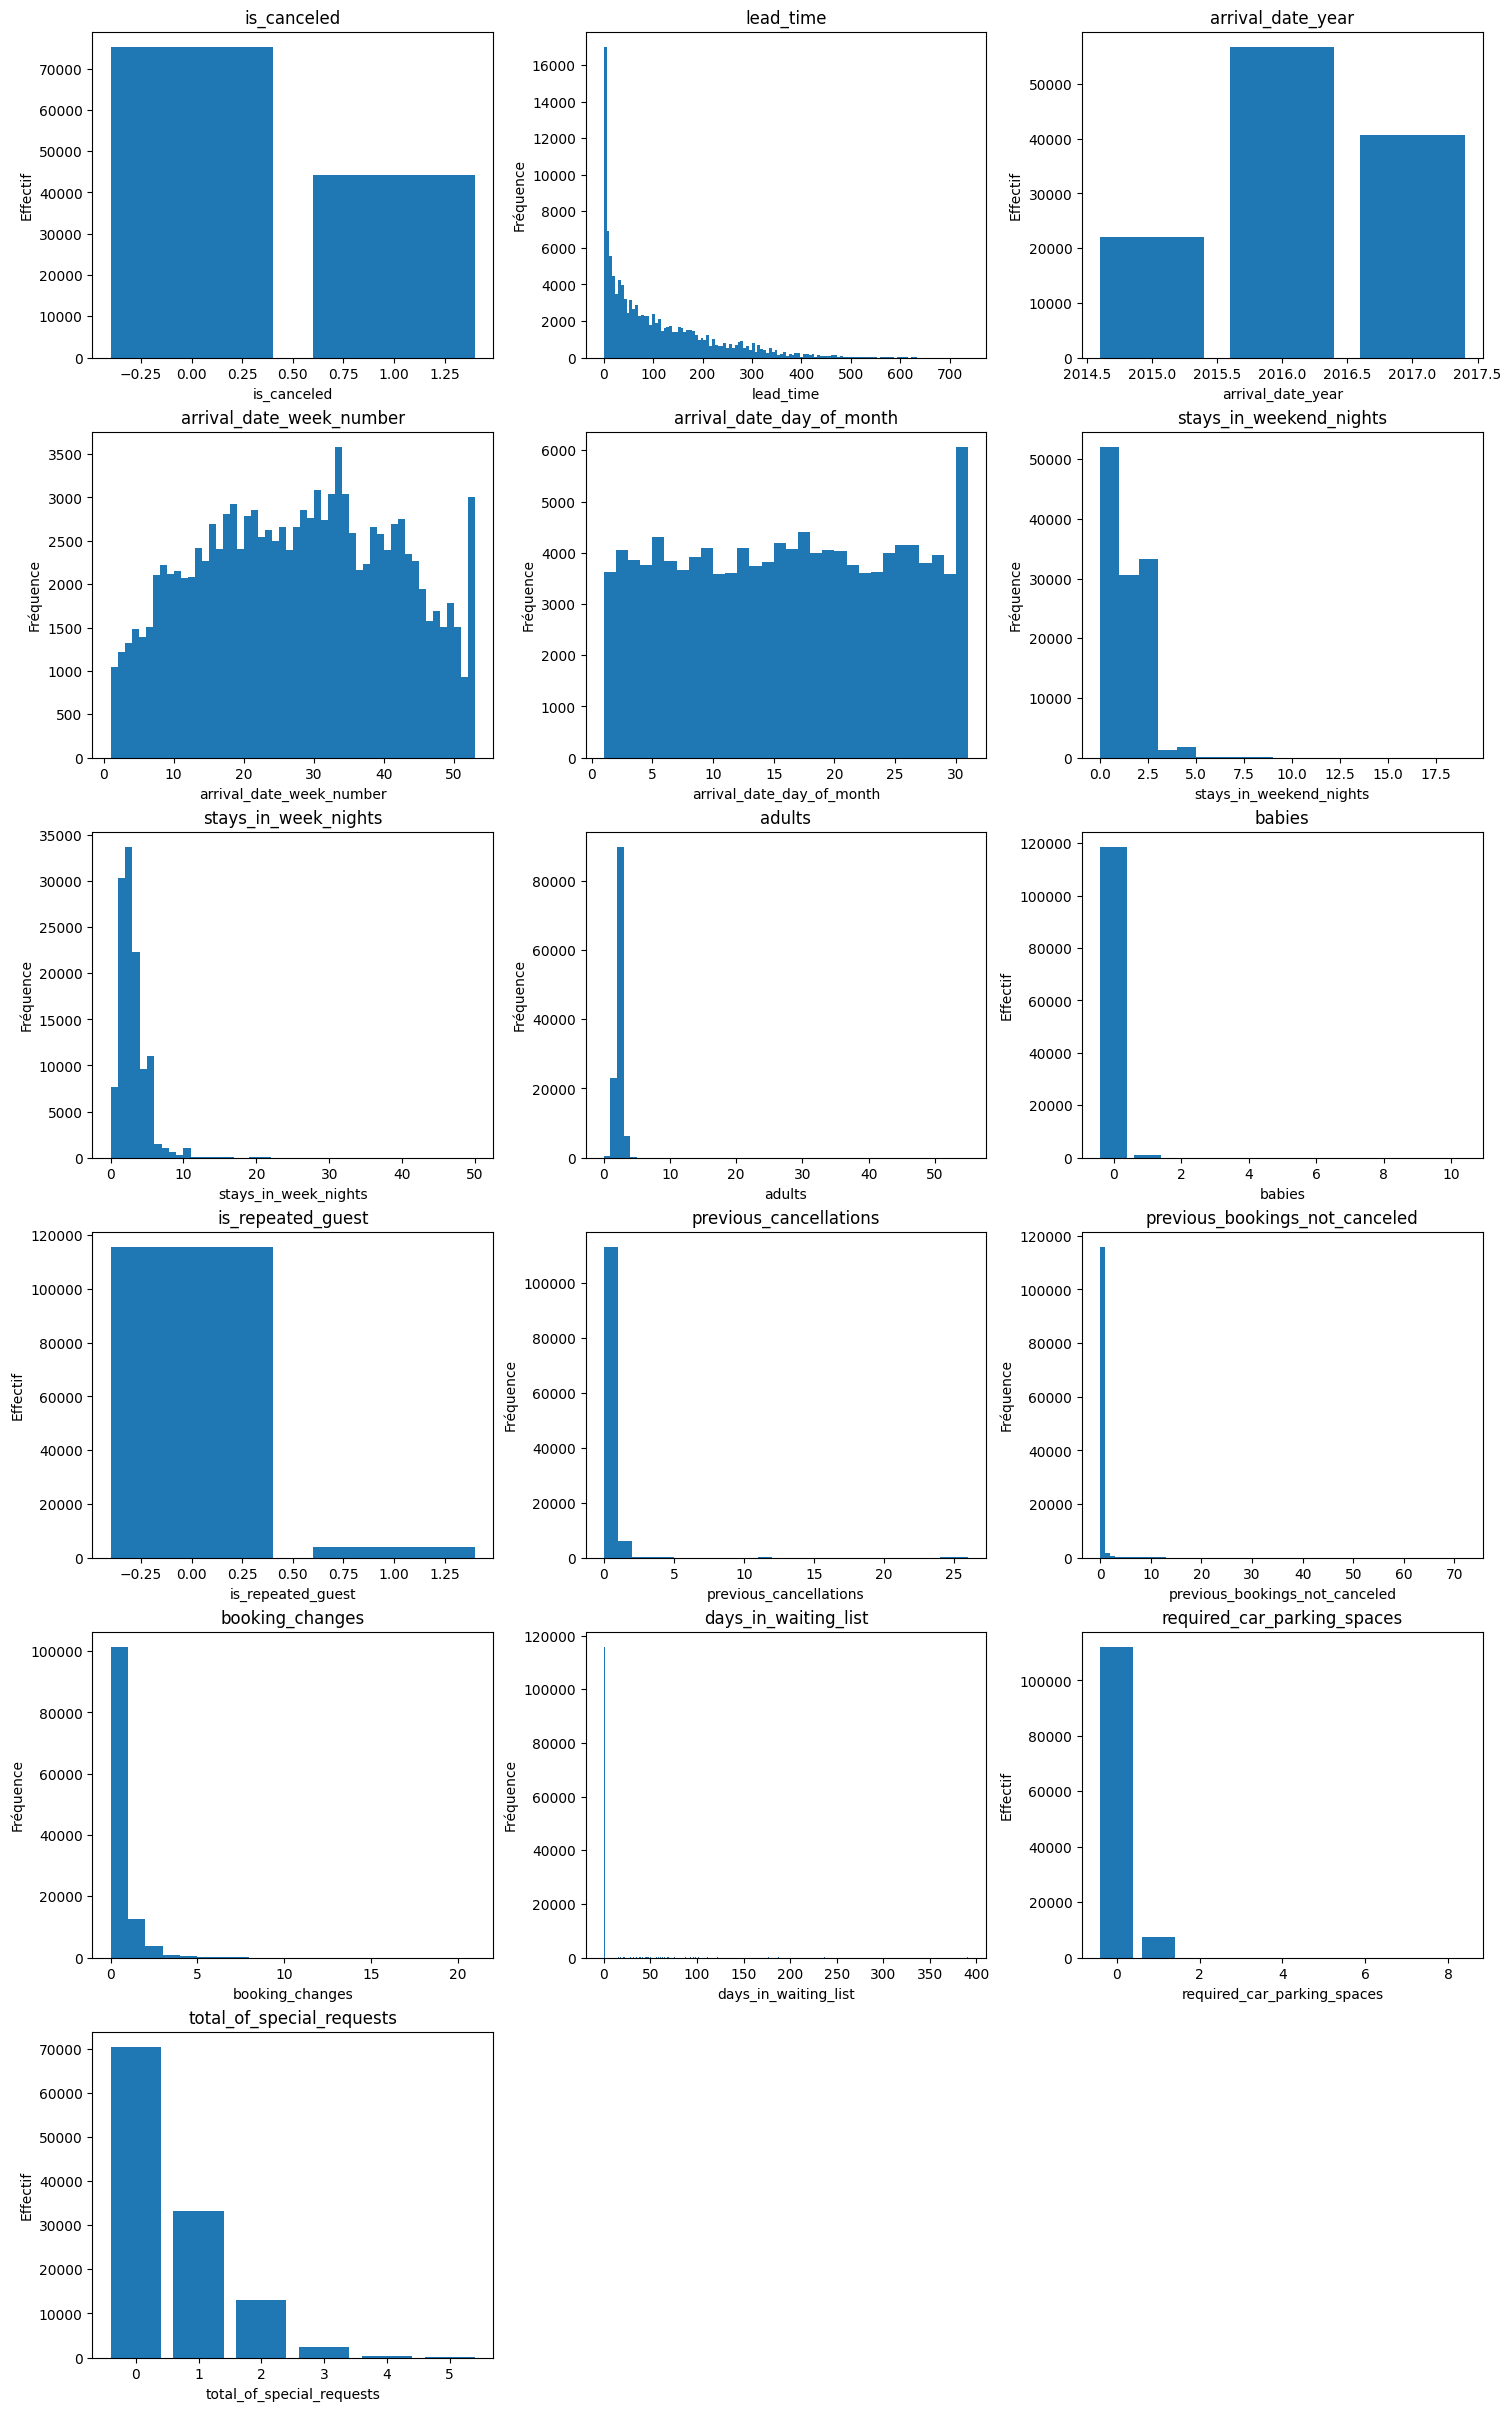

In [11]:
plot_grid_by_dtype(data, "int64")

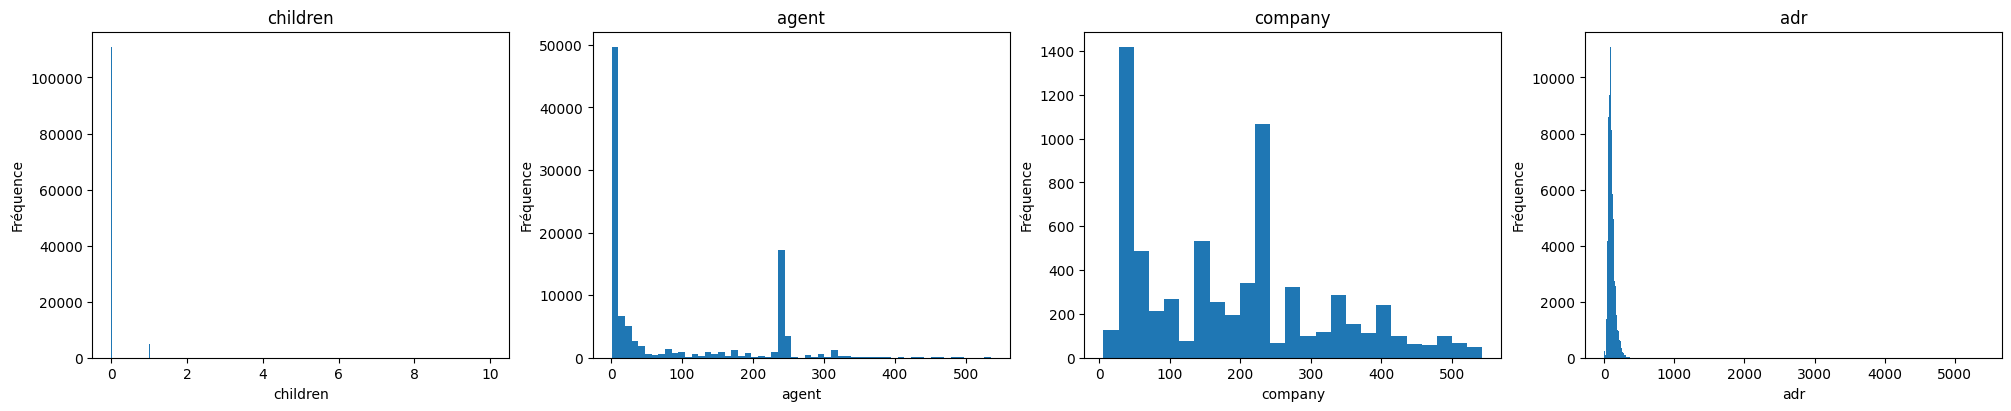

In [12]:
plot_grid_by_dtype(data, "float64", n_cols=4)

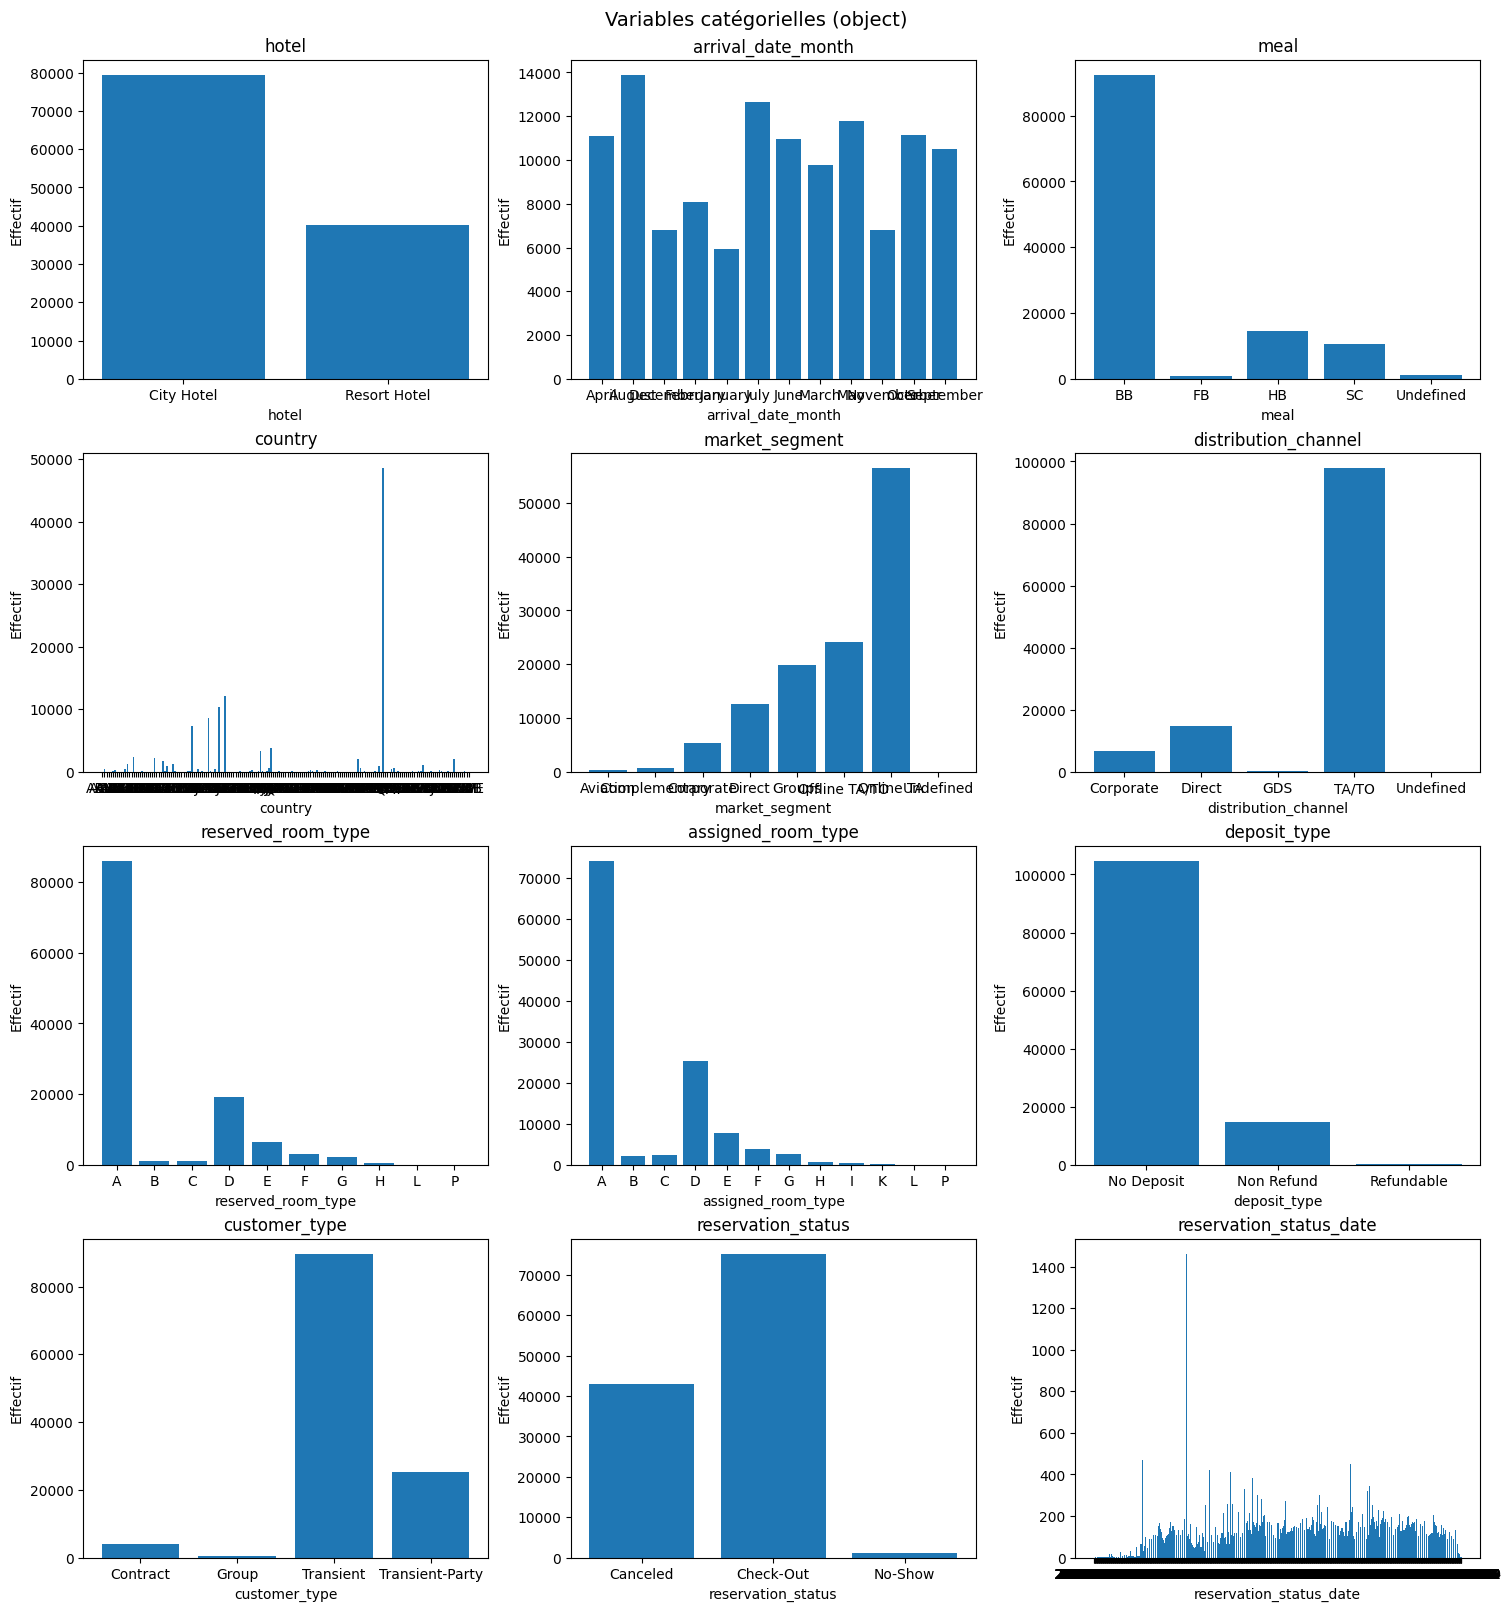

In [13]:
plot_grid_by_dtype(
    data, "object",
    categorical_threshold=5,
    title="Variables catégorielles (object)"
)

**Commentaires :** <br/>
La répartition du type de données n'était pas suffisant pour dire si une variable est catégorielle ou numérique. Nous allons répartir les éléments automatiquement pour commencer la séparation des variable en vu du développement de le pipeline. Par la suite, nous allons manuellement faire la répartition adéquate.

In [14]:
cat_cols = data.select_dtypes(exclude="number").columns.tolist()
num_cols = data.select_dtypes(include="number").columns.tolist()

In [15]:
extra_cat = [
    "is_canceled", "is_repeated_guest",
    "arrival_date_year", "arrival_date_week_number",
    "arrival_date_day_of_month",
    "required_car_parking_spaces",
    "country", "agent", "company"
]

for col in extra_cat:
    if col in data.columns:
        cat_cols.append(col)
        if col in num_cols:
            num_cols.remove(col)

In [16]:
print("Catégorielles : ", cat_cols)

Catégorielles :  ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status', 'reservation_status_date', 'is_canceled', 'is_repeated_guest', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'required_car_parking_spaces', 'country', 'agent', 'company']


In [17]:
print("Numérique : ", num_cols)

Numérique :  ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'total_of_special_requests']


### Est-ce que le jeux de données contient des données `na/null`?

In [18]:
null = pd.DataFrame({"Null" : data.isna().sum(), "Pourcentages des Null" : (data.isna().sum()) / (data.shape[0]) * (100)})
null.sort_values(by="Null", ascending=False).head().style.format("{:.2f}")

,Null,Pourcentages des Null
company,112593.00,94.31
agent,16340.00,13.69
country,488.00,0.41
children,4.00,0.00
reserved_room_type,0.00,0.00


In [19]:
print(data.company.unique()[0:10]) # finalement l'explication vient du papier

[ nan 110. 113. 270. 178. 240. 154. 144. 307. 268.]


In [20]:
print(data.agent.unique()[0:10]) # finalement l'explication vient du papier

[ nan 304. 240. 303.  15. 241.   8. 250. 115.   5.]


In [21]:
print(data.country.unique()[0:10]) # finalement l'explication vient du papier

['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' nan 'ROU' 'NOR' 'OMN']


In [22]:
print(data.children.unique())

[ 0.  1.  2. 10.  3. nan]


**Explication des données nulls et leurs traitements :**
- `company` : un `null/nan` ici veut tout simplement dire que la réservation n'a pas été faite au nom d'une entreprise. penser à mettre unknown
- `agent` : même cas que pour company, `null/nan` signifique que la réservation n'a pas eu d'agent intermédiaire ex : réservation sur le site de l'hôtel...
- `country` : la données n'est parfois complété qu'au moment d'arrivé en enregistrant le passeport
- `children` : on suppose un oubli de saisie, on va partir du principe que `nan/null` est égale à 0

In [23]:
values = {"company": "inconnue", "agent": "inconnue", "country": "inconnnue", "children": 0}
data = data.fillna(value=values)

In [24]:
null = pd.DataFrame({"Null" : data.isna().sum(), "Pourcentages des Null" : (data.isna().sum()) / (data.shape[0]) * (100)})
null.sort_values(by="Null", ascending=False).head().style.format("{:.2f}")

,Null,Pourcentages des Null
hotel,0.00,0.00
is_canceled,0.00,0.00
reservation_status,0.00,0.00
total_of_special_requests,0.00,0.00
required_car_parking_spaces,0.00,0.00


### Les données sont cohérentes ? Y a-t-il des erreurs de saisies ?
Règle métier en hotellerie, une chambre réservée doit avoir au moins 1 adulte ou un enfant ou un bébé dedans.

In [25]:
coherence = (data.children == 0) & (data.adults == 0) & (data.babies == 0)
data_filtered = data[coherence]
data_filtered[["is_canceled", "lead_time","children", "adults", "babies"]].tail()

,is_canceled,lead_time,children,adults,babies
115029,0,107,0.0,0,0
115091,0,1,0.0,0,0
116251,0,44,0.0,0,0
116534,0,2,0.0,0,0
117087,0,170,0.0,0,0


**Décision :** il est important de ne pas garder ces données incohérentes causée par une erreur de saisie j'ai donc filmé.

In [26]:
# Ne garder que les données pertinentes
data = data[~coherence]
data.shape

(119210, 32)

### Quel est le taux global d’annulation et son évolution mensuelle ?

In [27]:
data.is_canceled.unique()

array([0, 1])

In [28]:
count_canceled = (
    data["is_canceled"]
    .value_counts()
    .sort_index()
)
taux_annulation = count_canceled[1] / (count_canceled[0] + count_canceled[1])
print(f"Taux d'annulation global {round(taux_annulation * 100, 2)}%")

Taux d'annulation global 37.08%


In [29]:
data["reservation_status_date"] = pd.to_datetime(data["reservation_status_date"])
monthly_cancel_rate = (
    data.groupby(data["reservation_status_date"].dt.to_period("M"))["is_canceled"]
      .mean() * 100
)
monthly_cancel_rate.index = monthly_cancel_rate.index.to_timestamp()

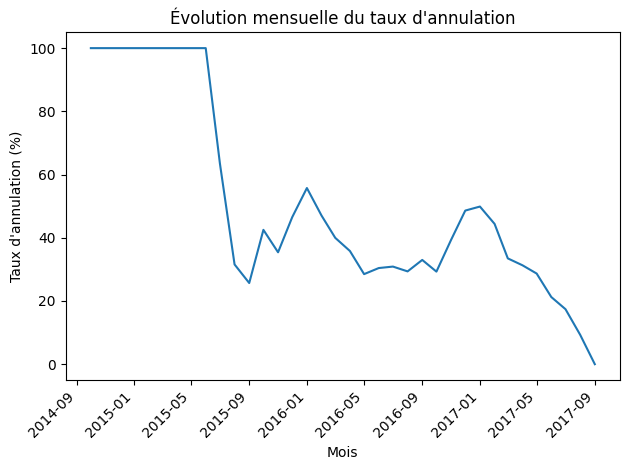

In [30]:
plt.figure()
monthly_cancel_rate.plot()
plt.xlabel("Mois")
plt.ylabel("Taux d'annulation (%)")
plt.title("Évolution mensuelle du taux d'annulation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analyse des variables critiques

### Le délai de réservation `lead_time` influence-t-il l’annulation ?

In [31]:
bins   = [-1, 30, 90, 180, float("inf")]
labels = ["≤30 j", "31-90 j", "91-180 j", "≥181 j"]

data["lead_bin"] = pd.cut(data["lead_time"], bins=bins, labels=labels)

In [32]:
cancel_rate = (
    data.groupby("lead_bin")["is_canceled"]
      .mean()              
      .mul(100)            
      .round(1)            
      .rename("% annul")
)

/var/folders/6j/prwx2hms3hzdtbw453ddk_k40000gn/T/ipykernel_5790/281490211.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby("lead_bin")["is_canceled"]


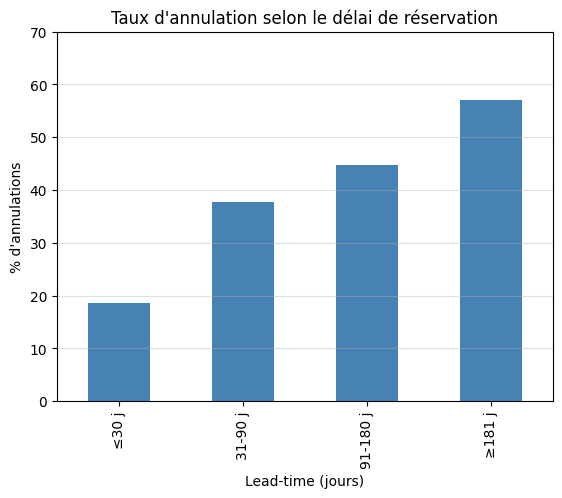

In [33]:
cancel_rate.plot(kind="bar", color="steelblue")
plt.title("Taux d'annulation selon le délai de réservation")
plt.xlabel("Lead-time (jours)")
plt.ylabel("% d'annulations")
plt.ylim(0, 70)
plt.grid(axis="y", alpha=.4)
plt.show()

**Conclusion :** on peut dire que plus les jours entre la date de réservation et la date d’arrivée est longue plus on a des annulations.

### Les réservations de dernière minute (< 48 h) annulent-elles moins ?	

In [34]:
data["last_minute"] = data["lead_time"] < 2 

In [35]:
cancel_rate_lm = (
    data.groupby("last_minute")["is_canceled"]
      .mean()
      .mul(100)
      .rename("% d'annulations")
)

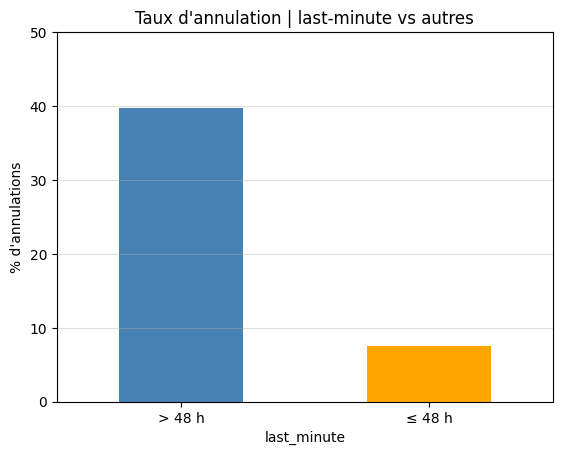

In [36]:
cancel_rate_lm.plot(kind="bar", color=["steelblue", "orange"])
plt.xticks([0,1], ["> 48 h", "≤ 48 h"], rotation=0)
plt.ylabel("% d'annulations")
plt.title("Taux d'annulation | last-minute vs autres")
plt.ylim(0, 50)
plt.grid(axis="y", alpha=.4)
plt.show()

**Conclusion :** On peut conclure que ceux qui réservent à la dernière minutes sont ceux qui annulent le moins.

### Un nombre élevé de modifications (booking_changes) augmente-t-il le risque ?	

In [37]:
data["booking_changes"].value_counts().head(10)

booking_changes
0    101232
1     12666
2      3780
3       914
4       367
5       115
6        61
7        29
8        14
9         8
Name: count, dtype: int64

In [38]:
data["chg_bin"] = pd.cut(data.booking_changes,
                       bins=[-1,0,1,float("inf")],
                       labels=["0", "1", "≥2"])

In [39]:
cancel_by_chg = (
    data.groupby("chg_bin")["is_canceled"]
      .mean()
      .mul(100)
      .round(1)
)

/var/folders/6j/prwx2hms3hzdtbw453ddk_k40000gn/T/ipykernel_5790/2842446171.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby("chg_bin")["is_canceled"]


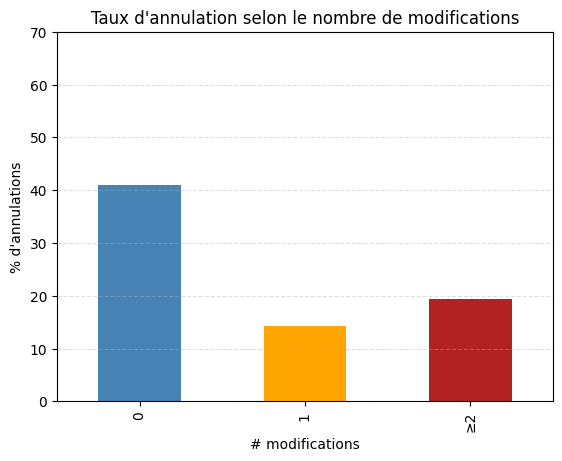

In [40]:
cancel_by_chg.plot(kind="bar", color=["steelblue","orange","firebrick"])
plt.ylabel("% d'annulations")
plt.xlabel("# modifications")
plt.title("Taux d'annulation selon le nombre de modifications")
plt.ylim(0,70)
plt.grid(axis="y", ls="--", alpha=.4)
plt.show()

**Conclusion** : on remarque que moins on a de modifications, moins on a d'annulation.

### Le mismatch de chambre (reserved_room_type ≠ assigned_room_type) est-il critique ?	

In [41]:
cancelled = data[data['is_canceled'] == 1]
not_cancelled = data[data['is_canceled'] == 0]

print("Annulations avec assigned_room_type différent :", 
      (cancelled['reserved_room_type'] != cancelled['assigned_room_type']).sum())

Annulations avec assigned_room_type différent : 801


In [42]:
print("Mismatch chez les annulés :", 
      (cancelled['reserved_room_type'] != cancelled['assigned_room_type']).mean()*100, "%")
print("Mismatch chez les non-annulés :", 
      (not_cancelled['reserved_room_type'] != not_cancelled['assigned_room_type']).mean()*100, "%")

Mismatch chez les annulés : 1.812258195886785 %
Mismatch chez les non-annulés : 18.65726360133847 %


Ce test nous montre que le mismatch de chambre ne cause pas d'annulation, au contraire, c'est plutôt protecteur contre l'annulation, la variable est contre-intuitive et potentiellement trompeuse

### Les clients récurrents (is_repeated_guest) annulent-ils moins ?	

In [43]:
cancel_repeat = (
    data.groupby("is_repeated_guest")["is_canceled"]
      .mean()
      .mul(100)
      .rename("% annulations")
)

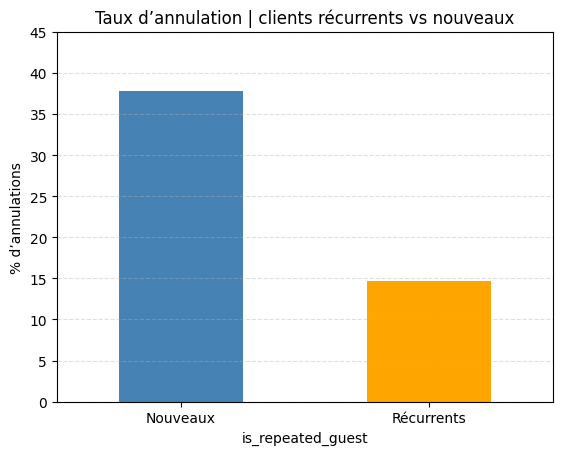

In [44]:
cancel_repeat.plot(kind='bar', color=['steelblue', 'orange'])
plt.xticks([0,1], ['Nouveaux', 'Récurrents'], rotation=0)
plt.ylabel('% d’annulations')
plt.title('Taux d’annulation | clients récurrents vs nouveaux')
plt.ylim(0, 45)
plt.grid(axis='y', ls='--', alpha=.4)
plt.show()

**Conclusion**: oui, les clients récurrents sont ceux qui annulent le moins.

## Impact économique et métriques métier

### Le prix `adr` est-il corrélé au risque ?

In [45]:
data["adr_q"] = pd.qcut(data["adr"], 4, labels=["Q1","Q2","Q3","Q4"])
cancel_by_price = (
    data.groupby("adr_q")["is_canceled"]
      .mean()
      .mul(100)
      .round(1)
)

/var/folders/6j/prwx2hms3hzdtbw453ddk_k40000gn/T/ipykernel_5790/1121479652.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby("adr_q")["is_canceled"]


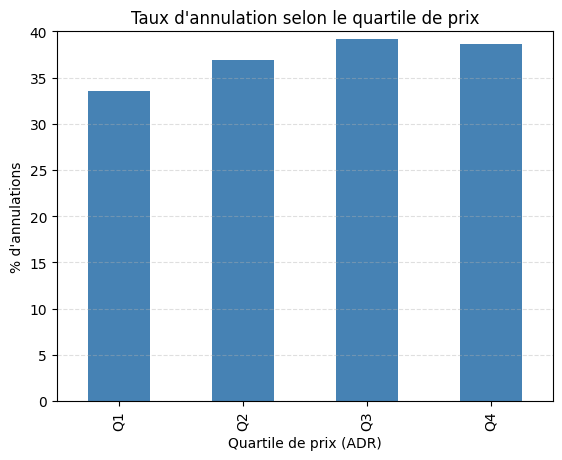

In [46]:
cancel_by_price.plot(kind="bar", color="steelblue")
plt.ylabel("% d'annulations")
plt.xlabel("Quartile de prix (ADR)")
plt.title("Taux d'annulation selon le quartile de prix")
plt.ylim(0,40); plt.grid(axis="y", ls="--", alpha=.4)
plt.show()

**Conclusion** : malgré la tendance montrant que les prix élevé augmente le taux d'annulation, on constate que la différence entre taux d'annulation sur q1 et les prix élevé est faible, ce qui nous fait dire que le prix n'est pas le principal facteur de risque d'annulation.

### Le dépôt `deposit_type` protège-t-il ?

In [47]:
cancel_by_deposit = (
    data.groupby("deposit_type")["is_canceled"]
      .mean()
      .mul(100)
      .round(1)
      .rename("% annul")
)

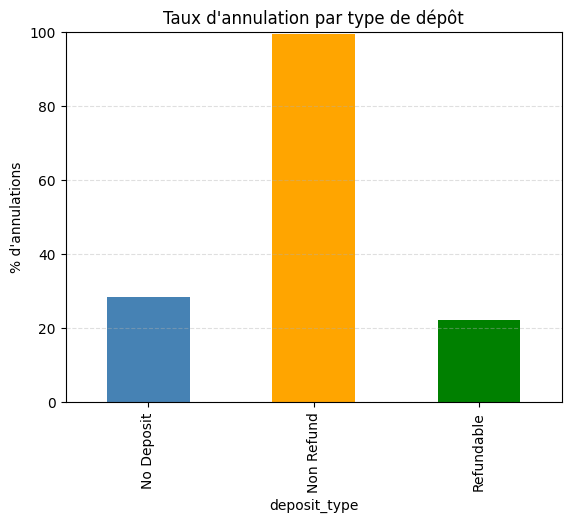

In [48]:
cancel_by_deposit.plot(kind="bar", color=["steelblue","orange","green"])
plt.ylabel("% d'annulations")
plt.title("Taux d'annulation par type de dépôt")
plt.ylim(0, 100)
plt.grid(axis="y", ls="--", alpha=.4)
plt.show()

In [49]:
pd.crosstab(data['deposit_type'], 'n')

col_0,n
deposit_type,
No Deposit,104461
Non Refund,14587
Refundable,162


In [50]:
pd.crosstab(
    data["deposit_type"],
    data["is_canceled"],
    normalize="index", 
    margins=True)

is_canceled,0,1
deposit_type,,
No Deposit,0.715980,0.284020
Non Refund,0.006376,0.993624
Refundable,0.777778,0.222222
All,0.629234,0.370766


**Conclusion** : le dépôt non remboursable ne protège pas contre les annulations.

### Le canal de distribution `distribution_channel` ou le segment de marché `market_segment` influence-t-il significativement le taux d'annulation ?

In [51]:
cancel_by_channel = (
    data.groupby("distribution_channel")["is_canceled"]
        .mean()
        .mul(100)
        .round(1)
        .sort_values()
)

cancel_by_segment = (
    data.groupby("market_segment")["is_canceled"]
        .mean()
        .mul(100)
        .round(1)
        .sort_values()
)

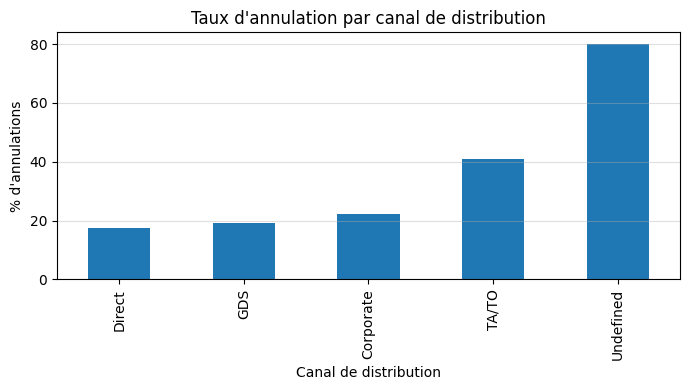

In [52]:
plt.figure(figsize=(7, 4))
cancel_by_channel.plot(kind="bar")
plt.title("Taux d'annulation par canal de distribution")
plt.xlabel("Canal de distribution")
plt.ylabel("% d'annulations")
plt.grid(axis="y", alpha=.4)
plt.tight_layout()
plt.show()

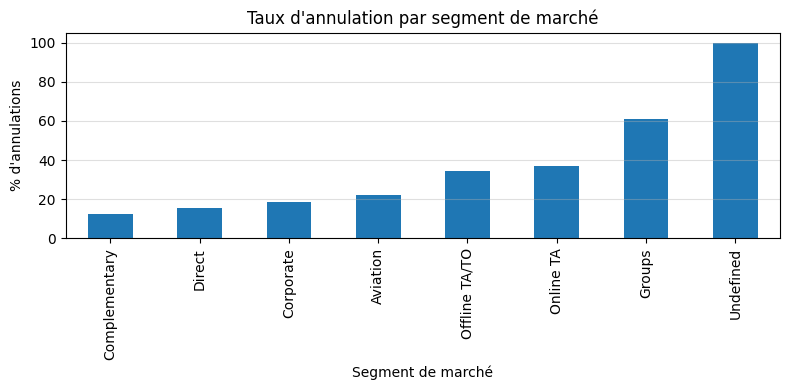

In [53]:
plt.figure(figsize=(8, 4))
cancel_by_segment.plot(kind="bar")
plt.title("Taux d'annulation par segment de marché")
plt.xlabel("Segment de marché")
plt.ylabel("% d'annulations")
plt.grid(axis="y", alpha=.4)
plt.tight_layout()
plt.show()

**Conclusion :** le taux d'annulation varie selon le canal de distribution et le segment de marché. Les réservations directes et corporate sont plus fiable tandis que celles issues des agences, de groupes ou de canaux non identifié présentent un risques d'annulation plus élevé. 

### Le nombre de demandes spéciales `total_of_special_requests` est-il associé à une diminution du risque d'annulation ?

In [54]:
cancel_by_special_requests = (
    data.groupby("total_of_special_requests")["is_canceled"]
        .mean()
        .mul(100)
        .round(1)
)

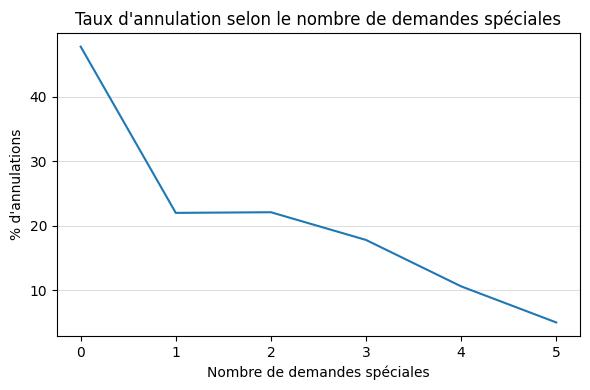

In [55]:
plt.figure(figsize=(6, 4))
#cancel_by_special_requests.plot(kind="bar")
cancel_by_special_requests.plot()
plt.title("Taux d'annulation selon le nombre de demandes spéciales")
plt.xlabel("Nombre de demandes spéciales")
plt.ylabel("% d'annulations")
plt.grid(axis="y", alpha=.4)
plt.tight_layout()
plt.show()

**Conclusion** : ce taux d'annulation qui diminue montre que les clients qui personnalisent leur séjour sont ceux qui annulent moins. 

### Le pays d'origine `country` est-il corrélé au comportement d'annulation ?

In [56]:
top_countries = (
    data["country"].value_counts()
    .head(50)
    .index
)

In [57]:
cancel_by_country = (
    data[data["country"].isin(top_countries)]
        .groupby("country")["is_canceled"]
        .mean()
        .mul(100)
        .round(1)
        .sort_values()
)

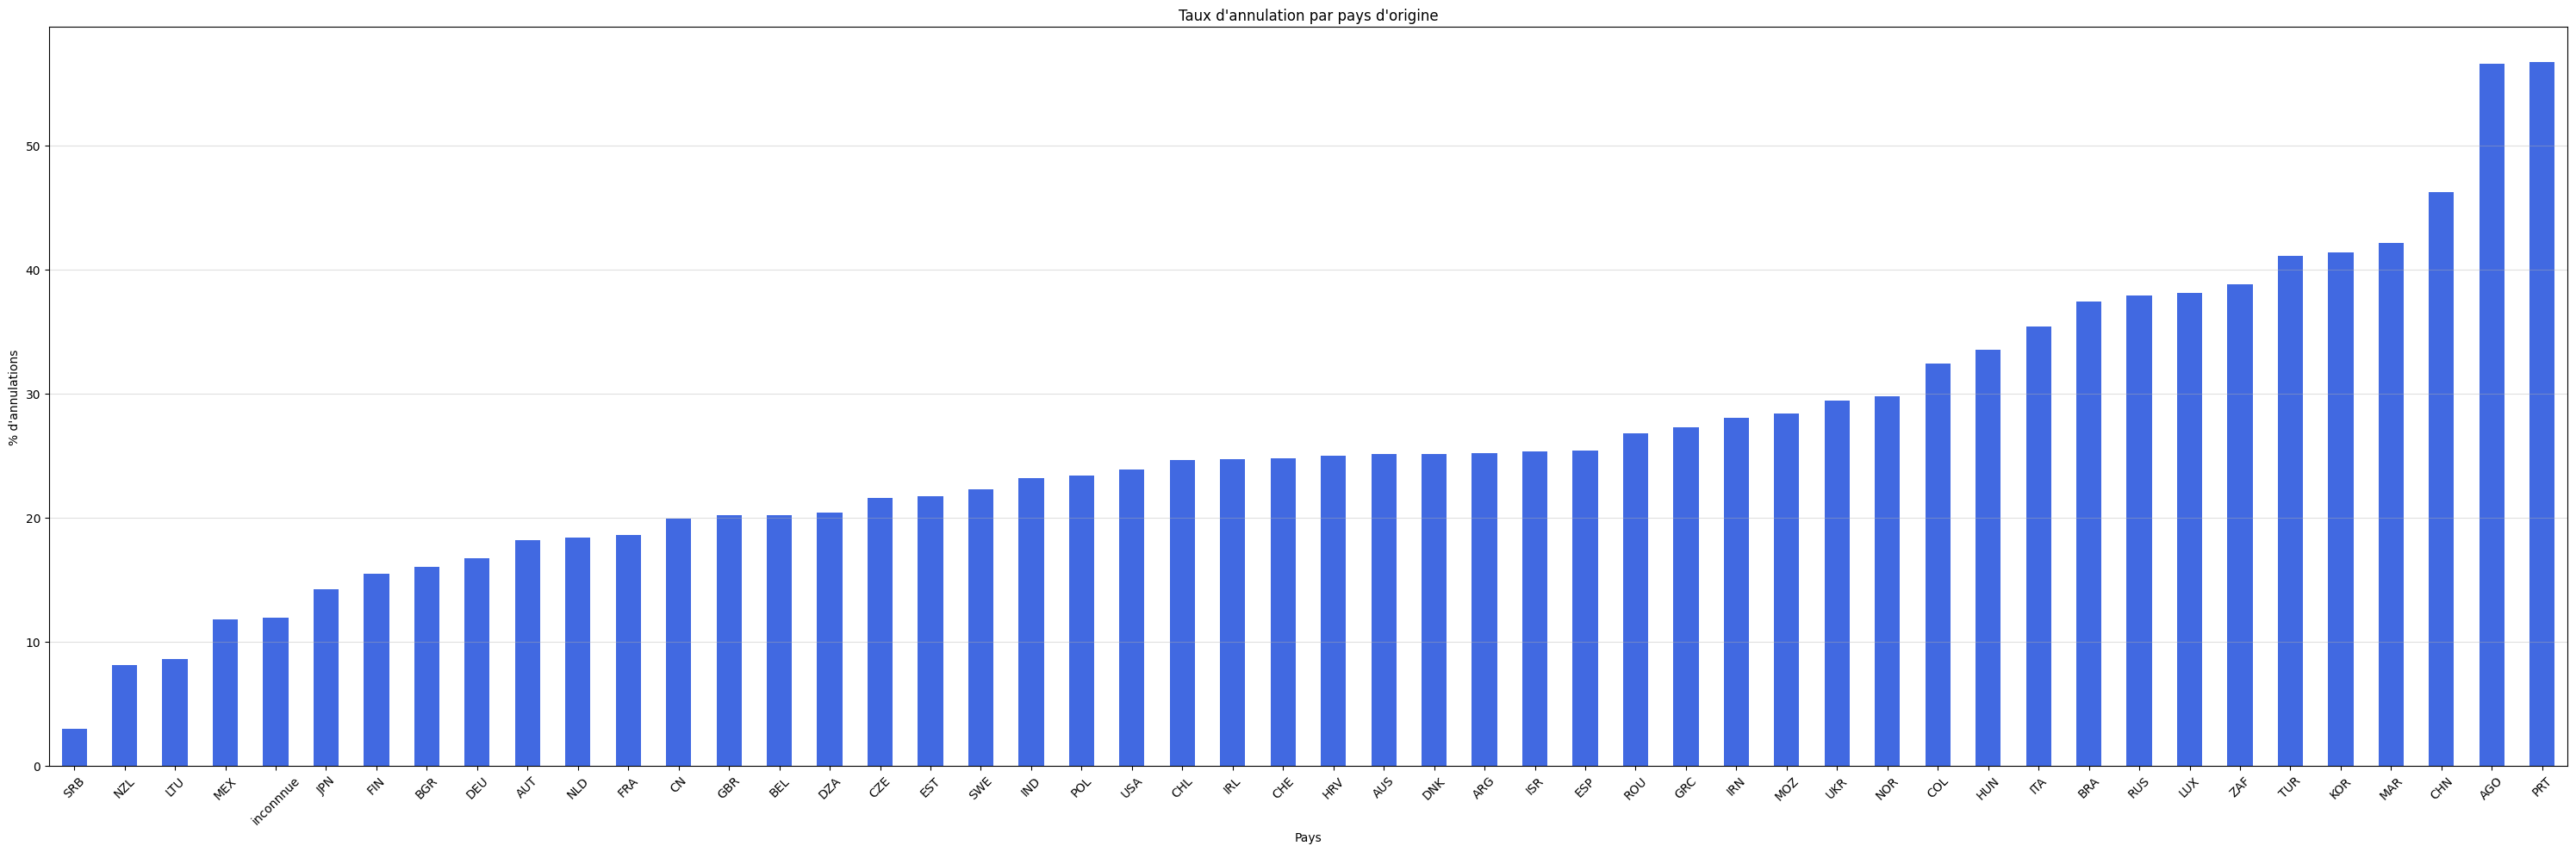

In [58]:
plt.figure(figsize=(30, 10))
cancel_by_country.plot(kind="bar", color="royalblue")
plt.title("Taux d'annulation par pays d'origine")
plt.xlabel("Pays")
plt.ylabel("% d'annulations")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=.4)
plt.tight_layout()
plt.show()

**Conclusion** : le taux d'annulation varie selon les pays. Les client dont on ne connait pas la nationalités sont ceux qui annulent le moins peut-être parce qu'on ne connait souvent leurs nationnalités que quand ils arrivent.

# [2-Clean] - Nettoyage et préparation des données

**Info** : Derniers nettoyages du dataset avant la modélisation. Il faut noter que le nettoyage des données null a déjà été fait dans l'exploration grâce aux informations du papier scientifique.

## Séparation catégorielles et numérique

In [59]:
print(f"Rappel des variables categoriels :\n{cat_cols}")

Rappel des variables categoriels :
['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status', 'reservation_status_date', 'is_canceled', 'is_repeated_guest', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'required_car_parking_spaces', 'country', 'agent', 'company']


In [60]:
print(f"Rappel des variables numériques :\n{num_cols}")

Rappel des variables numériques :
['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'total_of_special_requests']


In [61]:
cat_cols += ["lead_bin", "chg_bin", "adr_q", "last_minute"]
print(f"Les variables categoriels finaux :\n{cat_cols}")

Les variables categoriels finaux :
['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status', 'reservation_status_date', 'is_canceled', 'is_repeated_guest', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'required_car_parking_spaces', 'country', 'agent', 'company', 'lead_bin', 'chg_bin', 'adr_q', 'last_minute']


## Des données abérantes à supprimer ?

In [62]:
def iq_bounds(series, k=1.5):
    q1, q3 = np.percentile(series, [25, 75])
    iqr = q3 - q1
    return q1 - k * iqr, q3 + k * iqr

In [63]:
rows = []
for col in num_cols:
    low, high = iq_bounds(data[col].dropna())
    out_mask = ~data[col].between(low, high)
    rows.append({
        "variable": col,
        "borne_basse": round(low, 2),
        "borne_haute": round(high, 2),
        "nb_outliers": int(out_mask.sum()),
        "%_outliers": out_mask.mean() * 100
    })

outlier_summary = pd.DataFrame(rows).sort_values("%_outliers", ascending=False)
outlier_summary

,variable,borne_basse,borne_haute,nb_outliers,%_outliers
3,adults,2.00,2.00,29530,24.771412
8,booking_changes,0.00,0.00,17978,15.080950
4,children,0.00,0.00,8590,7.205771
6,previous_cancellations,0.00,0.00,6479,5.434947
10,adr,-15.25,210.75,3864,3.241339
9,days_in_waiting_list,0.00,0.00,3693,3.097894
7,previous_bookings_not_canceled,0.00,0.00,3613,3.030786
2,stays_in_week_nights,-2.00,6.00,3330,2.793390
0,lead_time,-196.50,375.50,2981,2.500629
11,total_of_special_requests,-1.50,2.50,2874,2.410872


**Décision :** certe statistiquement, on trouve des outliers mais dans une logique métier c'est une formation qu'il faut garder car ça montre la spécificité du client en effet. (exemple rapide : la majorité des clients de l'hotel sont des couples sans enfants qui ne modifient pas leurs réservation; mais l'hotel a aussi des clients différents, donc ce ne sont des spécifité que l'on veut donner au modèle).

## Exporter les données prétraités

In [64]:
use_cols = list()
for cols in num_cols:
    use_cols.append(cols)

for cols in cat_cols:
    use_cols.append(cols)

In [65]:
print(len(use_cols))
print(use_cols)

37
['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'total_of_special_requests', 'hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status', 'reservation_status_date', 'is_canceled', 'is_repeated_guest', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'required_car_parking_spaces', 'country', 'agent', 'company', 'lead_bin', 'chg_bin', 'adr_q', 'last_minute']


In [66]:
cols_to_remove = [
    "reservation_status",
    "reservation_status_date",
    "required_car_parking_spaces",
    "days_in_waiting_list",
    'arrival_date_year', 
]

# one-liner
use_cols = [c for c in use_cols if c not in cols_to_remove]

# or, in place:
for c in cols_to_remove:
    if c in use_cols:
        use_cols.remove(c)

**Info :** des suppression de colonnes sont nécessaire car inutile à donner au modèle pour faire la prédiction. 

In [67]:
print(len(use_cols))
print(use_cols)

32
['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'adr', 'total_of_special_requests', 'hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'is_canceled', 'is_repeated_guest', 'arrival_date_week_number', 'arrival_date_day_of_month', 'country', 'agent', 'company', 'lead_bin', 'chg_bin', 'adr_q', 'last_minute']


In [68]:
processed_data = data[use_cols]
processed_data.head().T

,0,1,2,3,4
lead_time,342,737,7,13,14
stays_in_weekend_nights,0,0,0,0,0
stays_in_week_nights,0,0,1,1,2
adults,2,2,1,1,2
children,0.0,0.0,0.0,0.0,0.0
babies,0,0,0,0,0
previous_cancellations,0,0,0,0,0
previous_bookings_not_canceled,0,0,0,0,0
booking_changes,3,4,0,0,0
adr,0.0,0.0,75.0,75.0,98.0


In [69]:
processed_data.to_csv("processed_hotel_bookings.csv", index=False)

In [70]:
test_data = pd.read_csv("processed_hotel_bookings.csv")
test_data.head().T

,0,1,2,3,4
lead_time,342,737,7,13,14
stays_in_weekend_nights,0,0,0,0,0
stays_in_week_nights,0,0,1,1,2
adults,2,2,1,1,2
children,0.0,0.0,0.0,0.0,0.0
babies,0,0,0,0,0
previous_cancellations,0,0,0,0,0
previous_bookings_not_canceled,0,0,0,0,0
booking_changes,3,4,0,0,0
adr,0.0,0.0,75.0,75.0,98.0


-- FIN --